# Issue Passport Details Credential

## This notebook walks through how to issue a credential across a newly established connection with a mobile SSI agent. 

## Before running through this notebook you should run through the following notebook - [Part 2](http://localhost:8889/notebooks/Part%202%20-%20Initialising%20the%20ID%20Verification%20Agent.ipynb).

If unfamiliar with the protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0036-issue-credential)


## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://id-verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Copy across the `schema_id` and `cred_def_id` stored in Part 2

In [3]:
%store -r cred_def_id
%store -r schema_id
print(cred_def_id)
print(schema_id)

6CJoFc4XQ1aXCSL33MowqX:3:CL:141253:default
2yWoMSfeTtYBFpUJFcnpqL:2:Passport Details:0.0.1


## 4. Populate the Passport Details to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [12]:
passport_num = input("Please enter the doctors pasport number: ")
surname=input("Please enter the doctors surname: ")
given_names=input("Please enter the doctors given names: ")
nationality = input("Please enter the doctors nationality: ")
dob=input("Please enter the doctors date of birth: ")
sex=input("Please enter the doctors gender: ")
place_of_birth = input("Please enter the doctors place of birth: ")
date_of_issue=input("Please enter passport issuance date: ")
issuing_auth=input("Please enter the issuing authority: ")
expiry_date = input("Please enter the expiry date: ")
photograph=input("Please enter a photograph of the doctor: ")
signature=input("Please enter your signature: ")
credential_attributes = [
    {"name": "PSS Passport No", "value": passport_num},
    {"name": "PSS Surname", "value": surname},
    {"name": "PSS Given Names", "value": given_names},
    {"name": "PSS Nationality", "value": nationality},
    {"name": "PSS Date of Birth", "value": dob},
    {"name": "PSS Sex", "value": sex},
    {"name": "PSS Place of Birth", "value": place_of_birth},
    {"name": "PSS Date of Issue", "value": date_of_issue},
    {"name": "PSS IssuingAuthority", "value": issuing_auth},
    {"name": "PSS Date of Expiry", "value": expiry_date},
    {"name": "PSS Photograph", "value": photograph},
    {"name": "PSS Signature", "value": signature}

]

# {'PSS Given Names', 
# 'PSS Date of Issue', 
# 'PSS Place of Birth', 
# 'PSS Date of Expiry', 
# 'PSS Sex', 
# 'PSS Date of Birth', 
# 'PSS Passport No', 
# 'PSS Nationality', 
# 'PSS Photograph', 
# 'PSS Signature', 
# 'PSS Surname', 
# 'PSS IssuingAuthority'}

# {'PSS Date of Issue', 
# 'PSS Given Names', 
# 'PSS Place of Birth', 
# 'PSS Sex', 
# 'PSS Date of Birth', 
# 'PSS Passport No', 
# 'PSS Nationality', 
# 'PSS Date Of Expiry', 
# 'PSS Photograph', 
# 'PSS Signature', 
# 'PSS Surname', 
# 'PSS IssuingAuthority'}

print(credential_attributes)

Please enter the doctors pasport number: 1234
Please enter the doctors surname: 1234
Please enter the doctors given names: 123
Please enter the doctors nationality: 123
Please enter the doctors date of birth: 123
Please enter the doctors gender: 123
Please enter the doctors place of birth: 1231
Please enter passport issuance date: 231
Please enter the issuing authority: 23
Please enter the expiry date: 312
Please enter a photograph of the doctor: 123
Please enter your signature: 123
[{'name': 'PSS Passport No', 'value': '1234'}, {'name': 'PSS Surname', 'value': '1234'}, {'name': 'PSS Given Names', 'value': '123'}, {'name': 'PSS Nationality', 'value': '123'}, {'name': 'PSS Date of Birth', 'value': '123'}, {'name': 'PSS Sex', 'value': '123'}, {'name': 'PSS Place of Birth', 'value': '1231'}, {'name': 'PSS Date of Issue', 'value': '231'}, {'name': 'PSS IssuingAuthority', 'value': '23'}, {'name': 'PSS Date of Expiry', 'value': '312'}, {'name': 'PSS Photograph', 'value': '123'}, {'name': 'PS

### 7. Make sure you have a Mobile SSI Wallet dowloaded and configured to using the Sovrin StagingNet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Create an Invitation

In [5]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'created_at': '2020-09-21 15:49:51.360361Z', 'initiator': 'self', 'invitation_key': 'FaPuSq9afjM25xBTsNG9eaiR6wJCxnaNCbbfHBrPG88o', 'accept': 'auto', 'invitation_mode': 'once', 'routing_state': 'none', 'connection_id': '1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7', 'updated_at': '2020-09-21 15:49:51.360361Z', 'state': 'invitation'} 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7
Connection ID 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7
Invitation
https://0d49b08d44fc.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNjBiYTRjN2ItY2MzNy00YzgzLThiZjAtODE1Y2RjYzUyOWY4IiwgInJlY2lwaWVudEtleXMiOiBbIkZhUHVTcTlhZmpNMjV4QlRzTkc5ZWFpUjZ3SkN4bmFOQ2JiZkhCclBHODhvIl0sICJsYWJlbCI6ICJJZGVudGl0eSBWZXJpZmljYXRpb24gU2V2aWNlIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovLzBkNDliMDhkNDRmYy5uZ3Jvay5pbyJ9


## 8b. Generate QR Code to be scanned with Mobile SSI Wallet

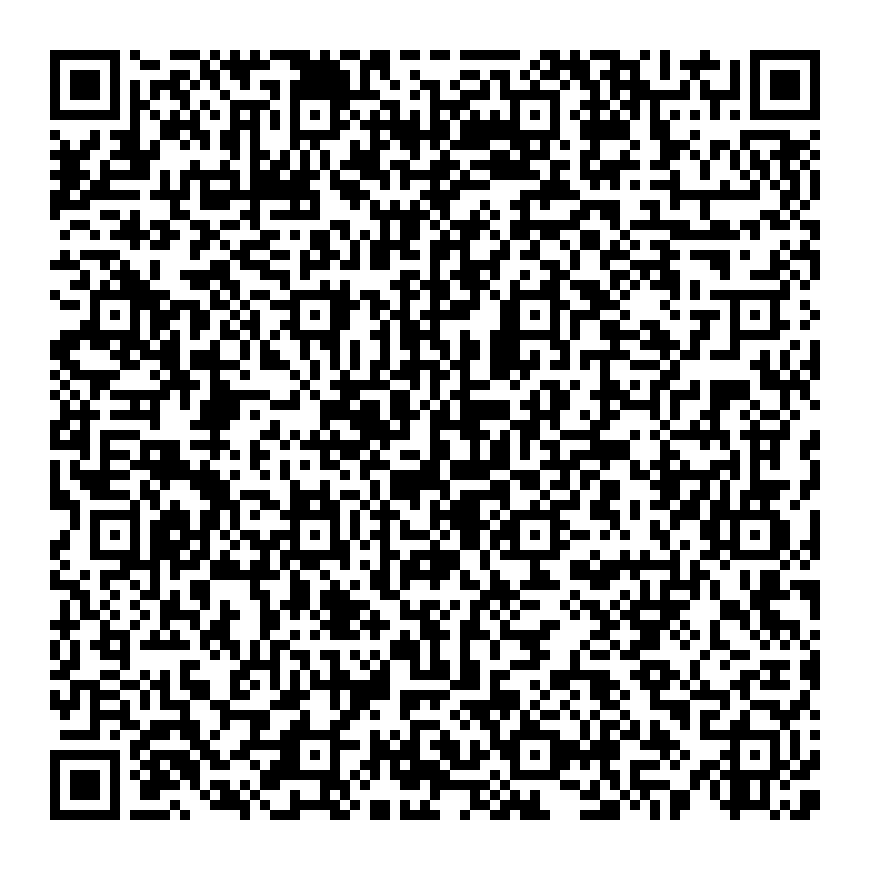

Connection message {'created_at': '2020-09-21 15:49:51.360361Z', 'initiator': 'self', 'invitation_key': 'FaPuSq9afjM25xBTsNG9eaiR6wJCxnaNCbbfHBrPG88o', 'their_label': 'EAX', 'accept': 'auto', 'their_did': 'XydyFB9obCUcTuLJDw239u', 'invitation_mode': 'once', 'routing_state': 'none', 'connection_id': '1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7', 'updated_at': '2020-09-21 15:50:09.245460Z', 'state': 'request'} 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7
Connection message {'created_at': '2020-09-21 15:49:51.360361Z', 'initiator': 'self', 'invitation_key': 'FaPuSq9afjM25xBTsNG9eaiR6wJCxnaNCbbfHBrPG88o', 'their_label': 'EAX', 'accept': 'auto', 'their_did': 'XydyFB9obCUcTuLJDw239u', 'invitation_mode': 'once', 'routing_state': 'none', 'my_did': '7eoSwumsH19LkBqDf2Tv35', 'connection_id': '1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7', 'updated_at': '2020-09-21 15:50:09.273872Z', 'state': 'response'} 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7


In [6]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('id-verifier-agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./id-verifier-agent_invite_QRcode.png')

## 8c. Check if established connection is in active state

In [7]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7 is response
ConnectionId 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7 is not in active state yet
Trust ping send to ConnectionId {'thread_id': 'd3243a6a-23e7-402a-94e7-b5ca78457a44'} to activate connection
ConnectionId 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7 is not in active state yet
Connection message {'created_at': '2020-09-21 15:49:51.360361Z', 'initiator': 'self', 'invitation_key': 'FaPuSq9afjM25xBTsNG9eaiR6wJCxnaNCbbfHBrPG88o', 'their_label': 'EAX', 'accept': 'auto', 'their_did': 'XydyFB9obCUcTuLJDw239u', 'invitation_mode': 'once', 'routing_state': 'none', 'my_did': '7eoSwumsH19LkBqDf2Tv35', 'connection_id': '1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7', 'updated_at': '2020-09-21 15:50:13.900888Z', 'state': 'active'} 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7
Connection 1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7 changed state to active
Trust ping send to ConnectionId {'thread_id': 'da352f74-209e-45f8-83c9-b55f7d96ee26'} to activate connection

## 9. Send Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [ ]:
print(connection_id, schema_id, cred_def_id, credential_attributes, "trace=False")

In [ ]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


In [15]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


1bfef2fb-b034-4ae1-b2a4-86c85eb2bef7 2yWoMSfeTtYBFpUJFcnpqL:2:Passport Details:0.0.1 6CJoFc4XQ1aXCSL33MowqX:3:CL:141253:default [{'name': 'PSS Passport No', 'value': '1234'}, {'name': 'PSS Surname', 'value': '1234'}, {'name': 'PSS Given Names', 'value': '123'}, {'name': 'PSS Nationality', 'value': '123'}, {'name': 'PSS Date of Birth', 'value': '123'}, {'name': 'PSS Sex', 'value': '123'}, {'name': 'PSS Place of Birth', 'value': '1231'}, {'name': 'PSS Date of Issue', 'value': '231'}, {'name': 'PSS IssuingAuthority', 'value': '23'}, {'name': 'PSS Date of Expiry', 'value': '312'}, {'name': 'PSS Photograph', 'value': '123'}, {'name': 'PSS Signature', 'value': '123'}] trace=False


In [16]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


ClientResponseError: 400, message="Preview attributes {'PSS Given Names', 'PSS Date of Issue', 'PSS Place of Birth', 'PSS Date of Expiry', 'PSS Sex', 'PSS Date of Birth', 'PSS Passport No', 'PSS Nationality', 'PSS Photograph', 'PSS Signature', 'PSS Surname', 'PSS IssuingAuthority'} mismatch corresponding schema attributes {'PSS Date of Issue', 'PSS Given Names', 'PSS Place of Birth', 'PSS Sex', 'PSS Date of Birth', 'PSS Passport No', 'PSS Nationality', 'PSS Date Of Expiry', 'PSS Photograph', 'PSS Signature', 'PSS Surname', 'PSS IssuingAuthority'}.", url=URL('http://id-verifier-agent:8051/issue-credential/send')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

## 10. Accept credential in Mobile SSI Wallet

## 11. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [13]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the Medical School  [Medical School](http://127.0.0.1:8888)

Here you will present the attributes issued to you within this tutorial to a verifying entity.